# Basics of BigDFT: first runs and managing different calculations, N2 molecule as example

This is a simple notebook that shows how to execute a simple calculation with BigDFT.
You will learn how to manipulate basic DFT objects from a python script.

We assume that the code has been installed and the correct environment variables are set.
See [this page](http://bigdft.org/Wiki/index.php?title=Prepare_the_environment) for more information.

## Atomic positions, examples of N2 Molecule

The atomic position of the systems to analyze can be provided via a input file (of a supported format), which enables to build an instance of a System class of BigDFT. We here consider the example of a Nitrogen molecule, that is taken from the internal database of the code.

In [1]:
from BigDFT.Database import Molecules as M
N2 = M.Molecule('N2')

Here a representation of the atomic positions in the internal format.

In [2]:
print (N2)

{'units': 'angstroem', 'positions': [{'frag': ['molecule', '0'], 'N': [0.0, 0.0, 0.5488]}, {'frag': ['molecule', '0'], 'N': [0.0, 0.0, -0.5488]}]}


We now run the DFT calculation (with the default input parameters) of this molecule.
This can be done by instanciating a class from the `Calculators` module.

In [3]:
from BigDFT import Calculators as C
study = C.SystemCalculator() #Create a calculator
log = study.run(posinp=N2) #run the code

Initialize a Calculator with OMP_NUM_THREADS=1 and command /home/genovese/binaries/1.9-py2/install/bin/bigdft
Creating the yaml input file "./default.yaml"
Executing command:  /home/genovese/binaries/1.9-py2/install/bin/bigdft


The `run()` method of the `BigDFT.Calculators.SystemCalculator` class shows in the standard output which is the 
command that is invoked.
Then, an instance of the `Logfile` class is returned.
Such class can be used (we will see after) to extract the information about the electronic structure of the system.

Now we can retrieve important informations on the run. See the examples below:

In [4]:
log.energy #this value is in Ha

-19.88461527324263

In [5]:
log.evals[0].tolist() # the eigenvalues in Ha ([0] stands for the first K-point, here meaningless)

[[-1.041353673208,
  -0.4926440819324,
  -0.4357815638016,
  -0.4357812404171,
  -0.3818323179544]]

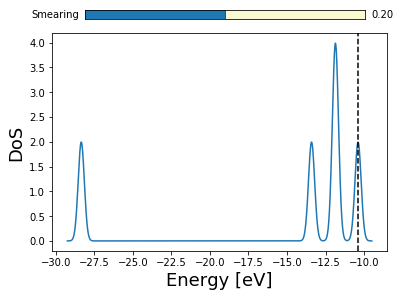

In [7]:
log.get_dos().plot() #the density of states

## How to modify the Input parameters from the default one

To specify non-default input parameters to the code, we should employ a `Inputfile` object. One can choose a naming prefix for a run, which enables to classify the runs which are performed, and ease the subsequent postprocessing.

Methods of the class can be employed for modifying the input parameters. For instance, the XC functional can be chosen via the `set_xc` method.
Imagine for example that you are interested in visualizing the wavefunctions output of the calculation. To do that, the suitable method of the class instance should be called.
Create a new calculation set by using, for instance, the `LDA` prefix.

In [8]:
from BigDFT import Inputfiles as I
inp = I.Inputfile()
inp.set_xc('LDA')
inp.write_orbitals_on_disk()

The wavefunctions will be present at the end of calculation, by indicating the value of the key *orbitals* in the output dictionary.

In [9]:
#Run the code with the LDA prefix
lda = study.run(name="LDA",input=inp,posinp=N2)

Creating the yaml input file "./LDA.yaml"
Executing command:  /home/genovese/binaries/1.9-py2/install/bin/bigdft -n LDA


When using a naming scheme, the output files are placed in a directory called  **data-LDA**. In our LDA example, the wavefunctions of the system can thus be found in the **data-LDA** directory:

In [13]:
!ls data-LDA

time-LDA.yaml			  wavefunction-k001-NR.bin.b000004
wavefunction-k001-NR.bin.b000001  wavefunction-k001-NR.bin.b000005
wavefunction-k001-NR.bin.b000002  wavefunction-rhoij.bin
wavefunction-k001-NR.bin.b000003


Here 001 means the first K-point (meaningless in this case), N stands for non spin-polarized, R for real part and the remaining number is the orbital ID. Post-processing of these files is done in the another tutorial.

In the same spirit, another calculation can be done with different parameters. Imagine we want to perform a Hartree-Fock calculation.
We should simply change the XC functional used. However, we also have to specify the pseudopotential.

In [10]:
inp.set_xc('HF')
inp['psppar.N']={'Pseudopotential XC': 1} #this set the default PSP for LDA
hf = study.run(name="HF",input=inp) #Run the code with the name scheme HF

Creating the yaml input file "./HF.yaml"
Executing command:  /home/genovese/binaries/1.9-py2/install/bin/bigdft -n HF


Without specifying the PSP, an error will occur. The same error is specified at the end of the log file, 
and also in [debug/bigdft-err-0.yaml](./debug/bigdft-err-0.yaml):
<pre>
 Additional Info:
   The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found 
   for "N"</pre>

This is because the pseudopotential is assigned by default in the code only for LDA and PBE XC approximations. You can find <a href="http://bigdft.org/images/f/f5/Psppar.N">here</a> the pseudopotential which is taken by default in the LDA run. Put it in a psppar.N file, and run the calculation.
Another alternative is to specify the internal PSP that might be used, taking from the default database of BigDFT. This can be done as follows:

In [ ]:
inp['psppar.N']={'Pseudopotential XC': 1} #here 1 stands for LDA as per the XC codes

When possible, care should be taken in choosing a pseudopotential which has been generated with the same XC approximation used. Unfortunately, at present HGH data are only available for semilocal functionals. For example, the same exercise as follows could have been done with Hybrid XC functionals, like for example PBE0 (ixc=-406). See the <a href="http://bigdft.org/Wiki/index.php?title=XC_codes">XC codes</a> for a list of the supported XC functionals. Data of the calculations can be analysed.

In [ ]:
inp.set_xc(inp,'PBE0')
pbe0 = study.run(name="PBE0",input=inp) #Run the code with the name scheme PBE0

The variables *lda*, *hf*, and *pbe0* contains all information about the calculation. This is a class Logfile which simplify considerably the extraction of parameters of the associated output file *log-LDA.yaml*. If we simply type:

In [15]:
from futile.Utils import write
write(lda)

- Atom types:
  - N
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.05670554140672
- Energy: -19.883483725688038
- Symmetry group: disabled
- fermi_level: -0.3812107719151
- Number of Atoms: 2
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 5



we display some information about the LDA calculation. For instance, we can extract the eigenvalues of the Hamiltonian *i.e.* the DOS (Density of States):

In [16]:
lda.evals[0].tolist()

[[-1.031892602676,
  -0.4970106443181,
  -0.4307276296665,
  -0.430727289646,
  -0.3812107719151]]

*lda.log* is the python dictionary associated to the full output file. 
The [tutorial](./Logfiles-Basic.ipynb) explains the basic methods. The following exercise (and its [solution](./Tutorial-N2-solution.ipynb)) gives some clues about it.

In [17]:
write(pbe0)

- Atom types:
  - N
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.1001956813857
- Energy: -19.968681994148028
- Symmetry group: disabled
- fermi_level: -0.4502961029675
- Number of Atoms: 2
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 5



# The overall structure of files in the disk
In the disk, after that the run is performed, different files are created:
* [input_minimal.yaml](./input_minimal) which contains the minimal set of input variables to perform the run;
* [log.yaml](./log.yaml) which contains the log of the run with all calculated quantities;
* [time.yaml](./time.yaml) and [forces_posinp.yaml](./forces_posinp.yaml) which we will see later.

For its I/O, `bigdft` uses the [yaml](http://www.yaml.org/spec) format.
If you look at the [input_minimal.yaml](./input_minimal) file, you can see:
<pre>
  #---------------------------------------------------------------------- Minimal input file
  #This file indicates the minimal set of input variables which has to be given to perform 
  #the run. The code would produce the same output if this file is used as input.
 posinp:
   units: angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
   properties:
     format: xyz
     source: posinp.xyz</pre>

In this case, only the atomic positions are indicated using a yaml format.

However, there is a one-to-one correspondence between a yaml file and a python dictionary. For this reason
we will create the input parameters of this runs from dictionaries. See the useful [yaml online parser](http://yaml-online-parser.appspot.com/) page to understand the correspondence.


In the log file [log.yaml](./log.yaml), BigDFT automatically displays all the input parameters used for the calculations. 

The parameters which were not explicitly given are set to a default value, except the atomic positions of course, which have to be given. As we did not specified input files here, our run is a single-point LDA calculation, without spin-polarisation.

<h2>Exercise</h2>

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA and the HF run.
Change the values of the hgrid and crmult to find the converged values.

Note that, both in the LDA and in the HF calculation, a norm-conserving PSP is used.

The results can be compared to all-electron calculations, done with different basis sets, from references (units are eV) 
(1) S.&nbsp;Hamel <i>et&nbsp;al.</i> J. Electron Spectrospcopy and Related Phenomena 123 (2002) 345-363 and (2) P.&nbsp;Politzer, F.&nbsp;Abu-Awwad, Theor. Chem. Acc. (1998), 99, 83-87:

eigenvalues          | LDA(1) | HF(1) | HF(2) | (Exp.)
---------------------|--------|-------|-------|-------
3&sigma;<sub>g</sub> | 10.36  | 17.25 | 17.31 | (15.60)
1&pi;<sub>u</sub>    | 11.84  | 16.71 | 17.02 | (16.98)
2&sigma;<sub>u</sub> | 13.41  | 21.25 | 21.08 | (18.78)

The results depends, of course, on the precision chosen for the calculation, and of the presence of the pseudopotential.
As it is well-known, the pseudopotential appoximation is however much less severe than the approximation induced by typical XC functionals. We might see that, even in the HF case, the presence of a LDA-based pseudopotential (of rather good quality) does not alter so much the results. 

Here you can find the values from BigDFT calculation using a very good precision (*hgrid=0.3*, *crmult=7.0*). 
Note that 1 ha=27.21138386 eV.
 
eigenvalues          | LDA   | HF
---------------------|-------|------
3&sigma;<sub>g</sub> | 10.40 | 17.32
1&pi;<sub>u</sub>    | 11.75 | 16.62
2&sigma;<sub>u</sub> | 13.52 | 21.30

How much do these values differ from the calculation with default parameters? Do they converge to a given value?
What is the *correlation* for the N2 molecule in (PSP) LDA?

See here the [solution](./Tutorial-N2-solution.ipynb).